In [2]:
import pyxdf
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
import mne
import bisect
import os

In [181]:
'''get data'''
xdf_path = 'eeg/sub-004_ses-S001_task-Default_run-001_eeg.xdf'
participant = '004'
data, header = pyxdf.load_xdf(xdf_path)

In [182]:
'''get stream'''

#find closest point
#not sure this function is still necessary 
def closest_point(target, time_stamps):
    #bisect right to prevent cutting into data
    index = bisect.bisect_right(time_stamps, target)
    #insert at the end if last 
    if index == len(time_stamps):
        return len(time_stamps)-1
    #find smallest difference
    if abs(time_stamps[index] - target) < abs(time_stamps[index - 1] - target):
        return index
    return index - 1

#find eeg stream
eeg_stream, marker_stream = None, None
for i, stream in enumerate(data):
    print(f'stream {i}: {stream['info']['name'][0]} - {stream['info']['type'][0]}')
    if stream['info']['name'][0] == 'eeg':
        eeg_stream = stream
    if stream['info']['name'][0] == 'LuckyMarkerStream':
        marker_stream = stream

#raise error if no stream
if eeg_stream == None:
    raise ValueError('no eeg stream')
if marker_stream == None:
    raise ValueError('no marker stream')    

#extract samples
eeg_samples = eeg_stream['time_series']
eeg_timestamps = eeg_stream['time_stamps'].astype('float')
markers = marker_stream['time_series']
marker_timestamps = marker_stream['time_stamps'].astype('float')

#every marker has its own timestamp --> collect
experiment_start = markers.index(['experimentStarted'])
experiment_end = markers.index(['experimentEnded'])
eeg_start = closest_point(marker_timestamps[experiment_start], eeg_timestamps)
eeg_end = closest_point(marker_timestamps[experiment_end], eeg_timestamps)
#cut data 
eeg_samples = eeg_samples[eeg_start:eeg_end,:]

print(f'data shapes --> {len(eeg_samples)} samples, {len(eeg_samples[0])} channels')

sampling_rate = int(float(eeg_stream['info']['nominal_srate'][0]))
#print(sampling_rate)
#get channel names
if 'desc' in eeg_stream['info']:
    ch_names = [ch['label'][0] for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']]
else:
    ch_names = [f'EEG {i+1}' for i in range(len(eeg_samples[0]))]

print(ch_names)
#MNE channels and MNE raw data object
#filter out accelarometers
eeg_ch = [x for x in ch_names if 'acc' not in x]
ch_types = ['eeg'] * len(eeg_ch) + ['misc'] * (len(ch_names) - len(eeg_ch))
info = mne.create_info(ch_names = ch_names, sfreq = sampling_rate, ch_types = ch_types)
raw = mne.io.RawArray(np.array(eeg_samples).T, info)

print(ch_types)

stream 0: LuckyMarkerStream - Markers
stream 1: eeg - data
data shapes --> 333107 samples, 19 channels
['Cz', 'Fp2', 'F3', 'Fz', 'F4', 'T7', 'C3', 'Fp1', 'C4', 'T8', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz', 'acc_x', 'acc_y', 'acc_z']
Creating RawArray with float64 data, n_channels=19, n_times=333107
    Range : 0 ... 333106 =      0.000 ...   666.212 secs
Ready.
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'misc', 'misc', 'misc']


In [183]:
'''rereferencing'''
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 19 x 333107 (666.2 s), ~48.3 MiB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16501 samples (33.002 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 249.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 249.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished


Plotting power spectral density (dB=True).


C:\Users\maart\AppData\Local\Temp\ipykernel_1752\3134423737.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(method='welch', picks='all')
C:\ProgramData\miniconda3\envs\prompts\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


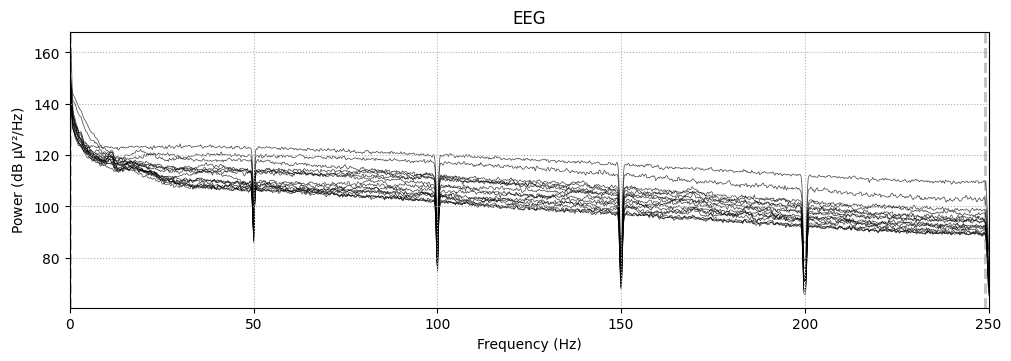

In [184]:
'''filtering'''
#high pass filter (1.0 Hz)
raw.filter(l_freq=0.1, h_freq=None)
#low pass filter nyquist --> 1/2 * sampling rate (- 1 to prevent error, fairly certain it already removes everything over nyquist)
raw.filter(l_freq=None, h_freq=(sampling_rate/2) - 1)
#raw.filter(l_freq=None, h_freq=100)
#50 Hz notch 
# = ['Cz', 'Fp2', 'F3', 'Fz', 'F4', 'T7', 'C3', 'Fp1', 'C4', 'Pz', 'P4', 'PO7', 'Oz' ]
raw.notch_filter([50, 100, 150, 200], picks='eeg')
#plot resulting signal
raw.plot_psd(method='welch', picks='all')

In [185]:
'''channel rejection'''
b_channels = [15]
b_channel_names = [x for i, x in enumerate(ch_names) if i + 1 in b_channels]
print(b_channel_names)
raw.info["bads"] = b_channel_names

['PO8']


Fitting ICA to data using 15 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 2.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 H

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 4.096 (s)
[2, 5, 6, np.int64(3)]


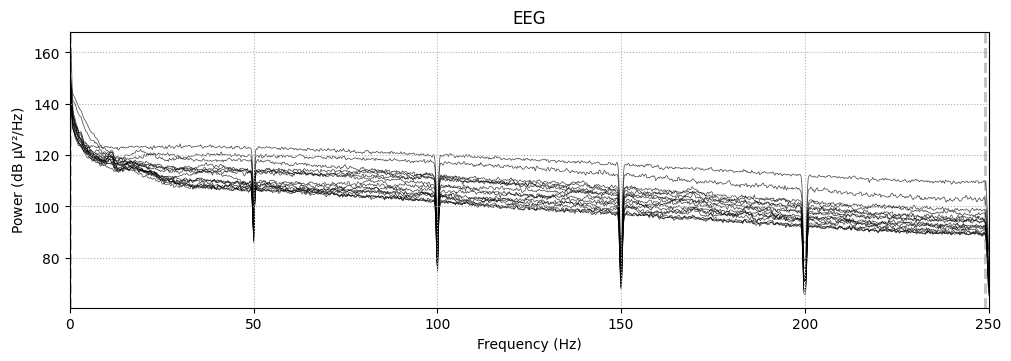

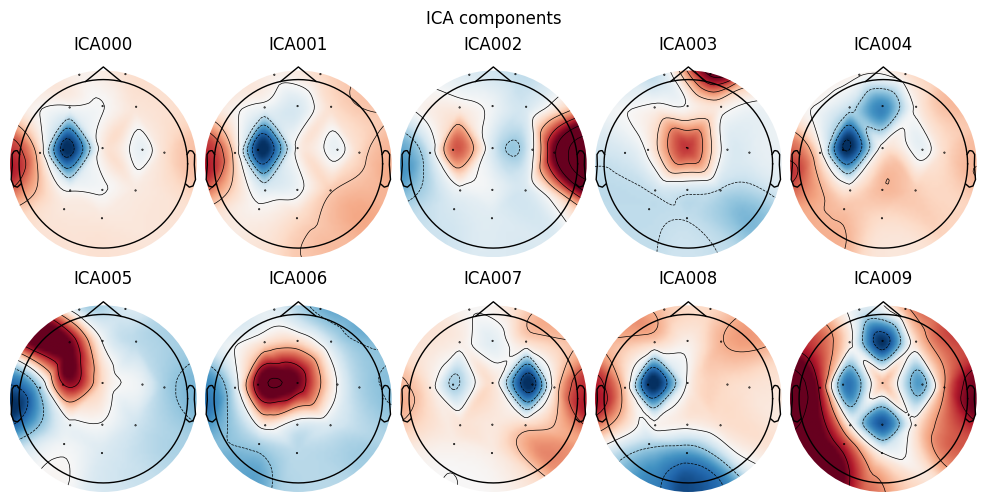

Creating RawArray with float64 data, n_channels=10, n_times=333107
    Range : 0 ... 333106 =      0.000 ...   666.212 secs
Ready.


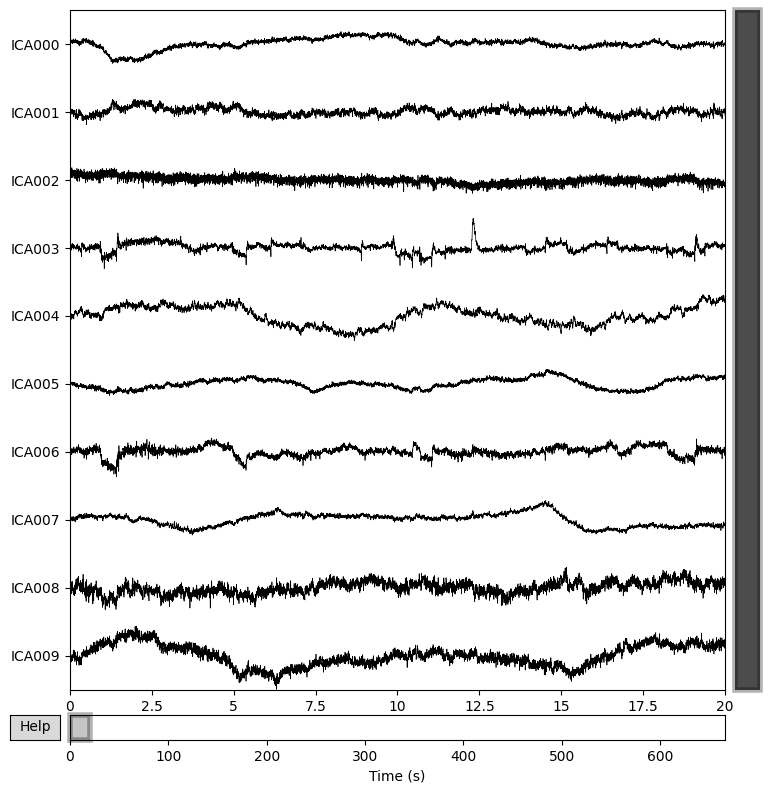

In [186]:
'''artifact rejection'''

#create montage for electrode names and locations
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
#start ICA
ica = ICA(n_components=10, random_state=97, max_iter=800)
less_raw = raw.copy()
#fit ica/run ica on raw data
ica.fit(raw)
#plot sources
#ica.plot_sources(raw)
ica.exclude = []
#correlation threshold 
correlation_threshold = 0.7 #0.75
#find artifacts based on frontal electrodes
eog_indices_1, eog_scores_1 = ica.find_bads_eog(raw, ch_name=['Fp1', 'Fp2'], measure='correlation', threshold=correlation_threshold)
muscle_indices, muscle_scores = ica.find_bads_muscle(raw, threshold=0.7)
print(muscle_indices + eog_indices_1)
ica.plot_components()
ica.plot_sources(raw)
#add found artifacts to mne exclude list
ica.exclude = eog_indices_1 + muscle_indices

In [187]:
'''apply ica to 'raw' signal'''
ica.apply(less_raw)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 4 ICA components
    Projecting back using 15 PCA components


<RawArray | 19 x 333107 (666.2 s), ~48.3 MiB, data loaded>

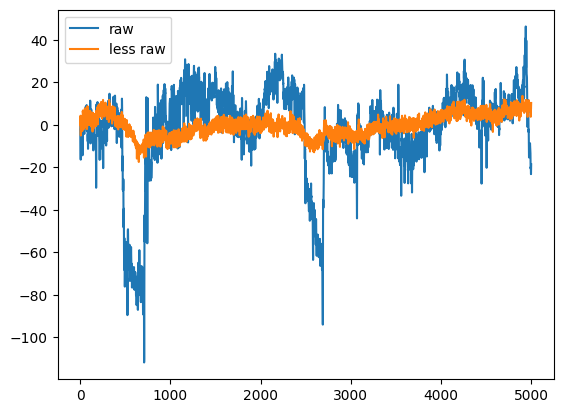

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 4 ICA components
    Projecting back using 15 PCA components


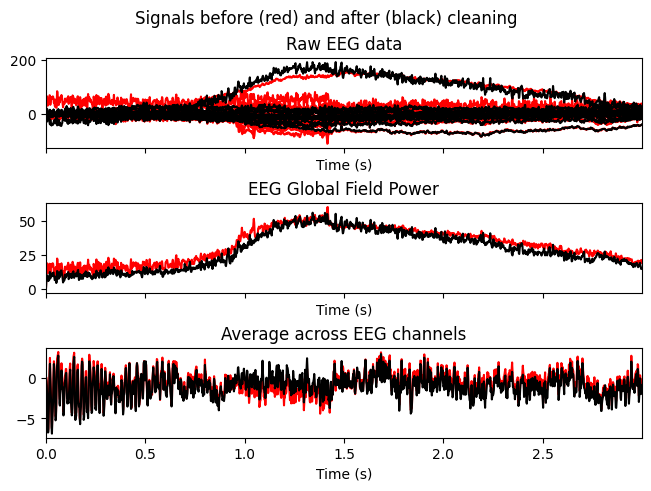

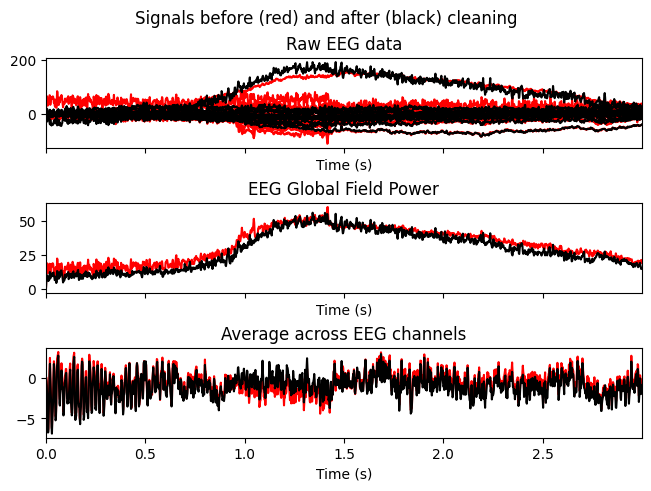

In [188]:
'''plot to check'''
plt.plot(raw[0][0][0, 0:5000], label='raw')
plt.plot(less_raw[0][0][0, 0:5000], label='less raw')
plt.legend()
plt.show()

ica.plot_overlay(raw)

In [189]:
''' hilbert transform to epoch frequency bands'''
hilbert_raw = less_raw.copy()
hilbert_raw = hilbert_raw.apply_hilbert(envelope=True)
hilbert = less_raw.get_data()

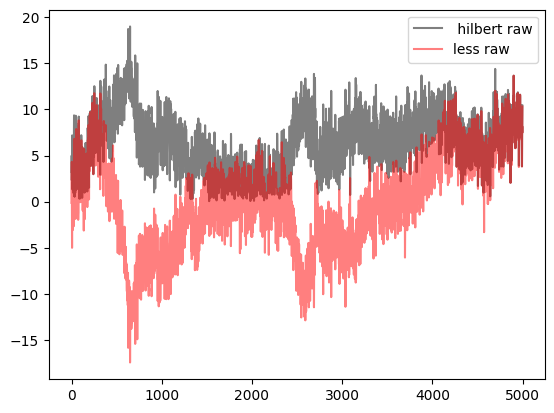

In [190]:
'''plot transformed data to check '''
plt.plot(hilbert_raw[0][0][0, 0:5000], label=' hilbert raw', alpha=0.5, color='black')
plt.plot(less_raw[0][0][0, 0:5000], label='less raw', alpha=0.5, color='red')
plt.legend()
plt.show()

In [191]:
'''define frequency bands and fill with transformed data'''

bands = {
    "Delta" : (0.1, 4),
    "Theta": (4, 8),
    "Alpha": (8,14), 
    "Beta": (14, 38),
    "Gamma": (38, 80),
    "High-gamma": (80, 120)
}
#add Deltaband
split_bands = {}
#hilbert transform
for band, (fmin, fmax) in bands.items():
    #pochs.load_data()
    split_bands[band] = hilbert_raw.copy().filter(l_freq=fmin, h_freq=fmax, picks='eeg')
    
delta_band = split_bands['Delta']
theta_band = split_bands['Theta']
alpha_band = split_bands['Alpha']
beta_band  = split_bands['Beta']
gamma_band = split_bands['Gamma']

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 16501 samples (33.002 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 473 samples (0.946 s)



[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 38 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 38.00
- Lower transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 33.25 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 175 samples (0.350 s)



[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 80 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 83 samples (0.166 s)



[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished


In [192]:
''' erp bands'''
erp_bands = {}
for band, (fmin, fmax) in bands.items():
    #pochs.load_data()
    erp_bands[band] = less_raw.copy().filter(l_freq=fmin, h_freq=fmax, picks='eeg')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 16501 samples (33.002 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 473 samples (0.946 s)



[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 38 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 38.00
- Lower transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 33.25 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 175 samples (0.350 s)



[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 80 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 83 samples (0.166 s)



[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished


In [193]:
'''create events structure for epoching'''
marker_timestamps_new=[ma-eeg_timestamps[0] for ma in marker_timestamps]
sample_indices = raw.time_as_index(marker_timestamps_new)
#collect markers and assign integer id (list index)
#epcoh to image
marker_ds = ['experimentStarted', 'experimentEnded', 'spin', '-1', '1', 'rating', 'jpg/png']

events = []
counter =0
#zip(marker ts, marker) --> 1. (ts, marker)
for i, (timestamp, marker) in enumerate(zip(sample_indices, markers)):
    #get timestamp event
    event_time = timestamp
    #print(event_time)
    #get event id based on index in the list
    if '.' in marker[0]:
        counter +=1 
        event_id = marker_ds.index('jpg/png')
    else:
        #convert marker into an integer for event_id
        event_id = int(marker_ds.index(marker[0].split(' ')[0]))  
    
    #only create event for spin (id 2)
    #events.append([event_time * raw.info['sfreq'], 0, event_id + 1])
    events.append([event_time, 0, event_id + 1])
print(counter)
events = np.array(events)

116


In [194]:
marker_ds[6]

'jpg/png'

In [195]:
def epoch_bands_erp(t_start, t_end):
    erp_epochs = {}
    epoched = {}
    for band in split_bands:
        epoched[band] = mne.Epochs(erp_bands[band], events=events.astype(int), event_id=7, tmin=t_start, tmax = t_end, reject=None, verbose=True, baseline=None)

    erp_epochs = epoched
    return erp_epochs

erps = epoch_bands_erp(-0.5, 1.5)

Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated


In [196]:
#erps['Delta'].drop_bad()
#erps['Delta'].selection
#m = np.array(markers)[erps['Delta'].selection]

#collect erp markers
erp_markers = {}
for band in erps:
    erps[band].drop_bad()
    erp_markers[band] = np.array(markers)[erps[band].selection]

Using data from preloaded Raw for 116 events and 1001 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 1001 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 1001 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 1001 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 1001 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 1001 original time points ...
1 bad epochs dropped


In [197]:
erp_markers['Delta']

array([['cold_1.jpg'],
       ['set_26_prompt_2_4.png'],
       ['set_41_prompt_1.png'],
       ['set_25_prompt_1_3.png'],
       ['set_27_prompt_3_4.png'],
       ['set_93.png'],
       ['set_67_prompt_2_4.png'],
       ['hot_1.jpg'],
       ['set_37.png'],
       ['office_supplies_1.jpg'],
       ['Win0€_1.jpg'],
       ['set_98.png'],
       ['licorice_1.jpg'],
       ['Loose100€_1.jpg'],
       ['set_53_prompt_1_1.png'],
       ['set_92.png'],
       ['acorns_1.jpg'],
       ['beach_1.jpg'],
       ['set_47_prompt_2_3.png'],
       ['set_3_prompt_2_2.png'],
       ['Loose2€_1.jpg'],
       ['noodles_1.jpg'],
       ['set_55_prompt_3_3.png'],
       ['set_64_prompt_2_2.png'],
       ['set_62_prompt_1_3.png'],
       ['vlaai_1.jpg'],
       ['set_52_prompt_1_3.png'],
       ['set_86.png'],
       ['sweets_1.jpg'],
       ['set_30_prompt_1_1.png'],
       ['beer_1.jpg'],
       ['set_31_prompt_3_4.png'],
       ['set_49_prompt_1_3.png'],
       ['hike_1.jpg'],
       ['set_19.png'],
 

In [198]:
#average general and personal signals per electrode per band

erp_data_split = {}
for band in erps:
    
    personal_erps, general_erps = [], []
    personal_mask = np.array([x[0].endswith('.png') for x in erp_markers[band]])
    general_mask = np.array([x[0].endswith('.jpg') for x in erp_markers[band]])

    personal_erps = erps[band][personal_mask]
    general_erps = erps[band][general_mask]
    #compute average per condition
    mean_personal_erp = np.mean(personal_erps, axis=0)
    mean_general_erp = np.mean(general_erps, axis=0)
    
    erp_data_split[band] = {'general' : general_erps, 'personal' : personal_erps}

                            


In [199]:
''' epoch bands in different windows '''

def epoch_bands_windowed(initial_t_start, window_length, offset, window_count):
    '''
    epochs hilbert transformed data in different frequency bands 
    initial_t_start   - start time after stimulus time stamp, also t_min of 
                        the first epochs
    window_length     - how long the window should be in seconds
    offset            - how much the window should shift in seconds
    window_count      - how many windows should be epoched
    '''
    windowed_epochs =  {}
    t_min = initial_t_start
    t_max = window_length + initial_t_start
    for window in range(window_count):
        t_min = initial_t_start + (offset * window)
        t_max = window_length + initial_t_start + (offset * window)
        windowed_epochs[window] = {'window index' : [t_min, t_max], 'bands': {}}
        #[t_min, t_max]
        epoched = {}
        for band in split_bands:
            #print(band)
            epoched[band] = mne.Epochs(split_bands[band], 
                                            events=events.astype(int), 
                                            event_id=7, 
                                            tmin=t_min, 
                                            tmax=t_max, 
                                            reject=None, 
                                            verbose=True, 
                                            event_repeated='merge', 
                                            baseline=None)
        #print(epoched)
        windowed_epochs[window]['bands'] = epoched
    
    return windowed_epochs

windowed_bands = epoch_bands_windowed(0.0, 0.5, 0.25, 4)

Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
116 matching eve

In [200]:
''' calculate average power per band per trial for windowed and epoched data'''
def calc_average_power(windowed_data_band):
    band_averages = []
    for j, trial in enumerate(range(windowed_data_band.shape[0])):
        #print(j, trial)
        trial_averages = []
        for i, channel in enumerate(range(windowed_data_band.shape[1])):
            #print(f'trial {trial} - trial num {j} - {i}, {test[trial, channel,:].mean()}')
            trial_averages.append(windowed_data_band[trial, channel, :].mean())
        band_averages.append(trial_averages)
    return band_averages

averaged_windowed_epochs = {}
selected_epochs = {}
for key in windowed_bands.keys():
    print(key)
    averaged_windowed_epochs[key] = {'window index' : windowed_bands[key]['window index'], 'bands': {}}
    selected_epochs[key] = {}
    for band in windowed_bands[key]['bands'].keys():
        band_data = windowed_bands[key]['bands'][band].get_data()
        selection = windowed_bands[key]['bands'][band].selection
        selected_epochs[key][band] = selection
        averaged_windowed_epochs[key]['bands'][band] = calc_average_power(band_data)

0
Using data from preloaded Raw for 116 events and 251 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 251 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 251 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 251 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 251 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 251 original time points ...
1 bad epochs dropped
1
Using data from preloaded Raw for 116 events and 251 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 251 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 251 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 116 events and 251 original time points ...
1 bad epochs dropped
Using 

In [201]:
len(averaged_windowed_epochs[2]['bands']['Theta'])

115

In [202]:
len(selected_epochs[2]['Delta'])

115

In [203]:
np.array(markers)[windowed_bands[1]['bands']['Delta'].selection]
mark = np.array(markers)

img = []
ratings = []
for m in mark:
    if m[0].endswith('.jpg') or m[0].endswith('.png'):
        img.append(m[0])
    elif 'rating' in m[0]:
        ratings.append(m[0])
        
combined = list(zip(img, ratings))
windowed_labels = {}
windowed_labels_masked = {}

for window in windowed_bands:
    selected_markers = np.array(markers)[windowed_bands[window]['bands']['Delta'].selection]
    print('selection', len(selected_markers))
    windowed_labels_masked[window] = []
    windowlabels, label_mask = [], []
    
    for (img, rating) in combined:
        if img in selected_markers:
            #true if personal
            label_mask.append(img.endswith('.png'))
            #print(rating.split(' ')[1])
            windowlabels.append(rating.split(' ')[1])
    #print(len(windowlabels))
    print('len mask', len(label_mask))
    windowed_labels_masked[window] = label_mask 
    windowed_labels[window] = windowlabels
        

selection 115
len mask 115
selection 115
len mask 115
selection 115
len mask 115
selection 115
len mask 115


In [204]:
len(windowed_labels_masked[3])

115

In [205]:
'''collect labels for machine learning pipeline

####labels for machine learning based on ratings
#get ratings
m = [x for x in markers if 'rating ' in x[0]]
#get just the number
l = [x[0].split(' ')[1] for x in m ]
#print(l)
#get spins to match with saved epochs
spins = [x for x in markers if 'spin'in x[0]]
labels = np.array(l)
spin_label_linked = zip(spins, labels)
#print(spin_label_linked)
#get saved events after epoching
m = np.array(markers)
#print(m)
#get all surviving markers from the epochs
se = m[epochs.selection].flatten().tolist()
#print(epochs.selection)
#filter so it matches (filter out spins (and ratings) not in the selected epochs)
final_label = []
for i, (spin, label) in enumerate(spin_label_linked):
    #print(spin, label, se[i])
    if label in se[i]:
        #print(label not in se[i])
        final_label.append(label)
'''

"collect labels for machine learning pipeline\n\n####labels for machine learning based on ratings\n#get ratings\nm = [x for x in markers if 'rating ' in x[0]]\n#get just the number\nl = [x[0].split(' ')[1] for x in m ]\n#print(l)\n#get spins to match with saved epochs\nspins = [x for x in markers if 'spin'in x[0]]\nlabels = np.array(l)\nspin_label_linked = zip(spins, labels)\n#print(spin_label_linked)\n#get saved events after epoching\nm = np.array(markers)\n#print(m)\n#get all surviving markers from the epochs\nse = m[epochs.selection].flatten().tolist()\n#print(epochs.selection)\n#filter so it matches (filter out spins (and ratings) not in the selected epochs)\nfinal_label = []\nfor i, (spin, label) in enumerate(spin_label_linked):\n    #print(spin, label, se[i])\n    if label in se[i]:\n        #print(label not in se[i])\n        final_label.append(label)\n"

In [206]:
''' get labels with epochs 
#get ratings
m = [x[0] for x in markers if 'rating ' in x[0]]
mm = [x.split(' ')[1] for x in m]
selected_labels = np.array(markers)[epochs.selection].flatten().tolist()
#m[epochs.selection].flatten().tolist()'''

" get labels with epochs \n#get ratings\nm = [x[0] for x in markers if 'rating ' in x[0]]\nmm = [x.split(' ')[1] for x in m]\nselected_labels = np.array(markers)[epochs.selection].flatten().tolist()\n#m[epochs.selection].flatten().tolist()"

In [207]:
'''collect labels for machine learning pipeline windows
    ratings as machine learning pipeline labels while epoched around images

NOT WORKING

selected_labels = {}
#for every band check which epoochs were saved
#based on saved epochs pull markers into dict, seperated by window
images = [x[0] for x in markers if 'jpg' in x[0] or 'png' in x[0]]
ratings = [x[0] for x in markers if 'rating' in x[0]]
images_and_ratings = zip(images, ratings)
#print(len(list(images_and_ratings)))
for w in windowed_bands:
    selected_labels[w] = []
    for b in windowed_bands[w]['bands']:
        l = np.array(markers)[windowed_bands[w]['bands'][b].selection]
        l_flat = [x for xs in l for x in xs]
        for (image, rating) in images_and_ratings:
            if image in l_flat:
                ll.append(rating)
            else:
                print(image, rating)
        print(ll)
        lll = [x.split(' ')[1] for x in ll]
        selected_labels[w] = lll

'''

"collect labels for machine learning pipeline windows\n    ratings as machine learning pipeline labels while epoched around images\n\nNOT WORKING\n\nselected_labels = {}\n#for every band check which epoochs were saved\n#based on saved epochs pull markers into dict, seperated by window\nimages = [x[0] for x in markers if 'jpg' in x[0] or 'png' in x[0]]\nratings = [x[0] for x in markers if 'rating' in x[0]]\nimages_and_ratings = zip(images, ratings)\n#print(len(list(images_and_ratings)))\nfor w in windowed_bands:\n    selected_labels[w] = []\n    for b in windowed_bands[w]['bands']:\n        l = np.array(markers)[windowed_bands[w]['bands'][b].selection]\n        l_flat = [x for xs in l for x in xs]\n        for (image, rating) in images_and_ratings:\n            if image in l_flat:\n                ll.append(rating)\n            else:\n                print(image, rating)\n        print(ll)\n        lll = [x.split(' ')[1] for x in ll]\n        selected_labels[w] = lll\n\n"

In [208]:
''' mask which labels correspond to personalized(true)/generalized(false) images 
images = [x for x in marker_stream['time_series'] if x[0].find('_') != -1]
image_mask = ['set' in x[0] for x in images]

print(len(image_mask))
#for i, image in enumerate(image_mask):
    #print(image, images[i], i)'''




" mask which labels correspond to personalized(true)/generalized(false) images \nimages = [x for x in marker_stream['time_series'] if x[0].find('_') != -1]\nimage_mask = ['set' in x[0] for x in images]\n\nprint(len(image_mask))\n#for i, image in enumerate(image_mask):\n    #print(image, images[i], i)"

In [209]:
''' save everything '''
#epochs/participant --> normal epochs/, band \epochs/
general_save_path = f'epochs_2/{participant}/'
save_file = '.npy'
epoch_file_name = f'{participant}-unsplit.npy'
#event_count = len(epochs.events)


if not os.path.exists(general_save_path):
    os.makedirs(f'{general_save_path}')

#save windowed data and their labels
for window in averaged_windowed_epochs:
    for band in averaged_windowed_epochs[window]['bands']:
        np.save(f'{general_save_path}{participant}_w{window}_{band}.npy', averaged_windowed_epochs[window]['bands'][band])
    np.save(f'{general_save_path}{participant}_w{window}_labels.npy', windowed_labels[window])
    np.save(f'{general_save_path}{participant}_w{window}_labels_masked.npy', windowed_labels_masked[window])
        
#save window stamps/indexes for clarity
window_stamps = []
for window in averaged_windowed_epochs:
    print(averaged_windowed_epochs[window]['window index'])
    window_stamps.append(averaged_windowed_epochs[window]['window index'])
    np.save(f'{general_save_path}window_stamps.npy', window_stamps)


#full_array = epochs.get_data()
#print(full_array.shape)
#full_array = full_array.reshape(event_count, -1)
#erp data
#np.save(f'{general_save_path}{epoch_file_name}', full_array)
#np.save(f'{general_save_path}{participant}-labels.npy', final_label)
#np.save(f'{general_save_path}{participant}-labels_masked.npy', image_mask)

#save erp data dictionary and labels
np.savez(f'{general_save_path}{participant}_erp_data.npz', **erp_data_split)
np.savez(f'{general_save_path}{participant}_erp_labels.npz', **erp_markers)

[0.0, 0.5]
[0.25, 0.75]
[0.5, 1.0]
[0.75, 1.25]
